# Multimodal Similarity Search on the WikiArt Dataset


In this notebook, we build a similarity search tool capable of searching a dataset of text and images. For the dataset, we use WikiArt, which contains over 100k Western art paintings along with their titles, artists, and other metadata. For the embedding model, we use the well-known CLIP model, which can embed text and images into the same latent space. We will demonstrate how to search for a painting matching the query with the painting titles (text) and the thumbnails (images) separately, then using a reranker to combine results.

First, our imports:

In [ ]:
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

import base64
from io import BytesIO
from datasets import load_dataset
import glob
from IPython.display import display, Image
import json
import numpy as np
from pymilvus import AnnSearchRequest
from pymilvus import FieldSchema, CollectionSchema, DataType, connections, Collection
from pymilvus import RRFRanker
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.transforms import (
    CenterCrop,
    ConvertImageDtype,
    Normalize,
    Resize,
    ToTensor,
    ToPILImage,
)
from torchvision.transforms.functional import InterpolationMode

# 1. Embed images and text into the same cross-modal space


## (a) Load the CLIP multimodal embedding models


First, we load our image and text encoders, which are pre-trained neural networks that convert the image and text into 512-dimensional embeddings. These encoders are designed so that the image and text embeddings will be close to each other in space if they are semantically similar.

We use the [CLIP](https://arxiv.org/abs/2103.00020) model, which is freely available and can be easily loaded with the HuggingFace suite of libraries. For more details, refer to [this notebook](https://colab.research.google.com/drive/1bLVwVKpAndpEDHqjzxVPr_9nGrSbuOQd?usp=sharing) and [this documentation](https://huggingface.co/docs/transformers/en/model_doc/clip). For the technically curious, the image encoder relies on a [vision transformer (ViT)](https://arxiv.org/abs/2010.11929), while the text encoder uses the same transformer decoder-only architecture as [GPT-2](https://openai.com/index/better-language-models/), a precursor to ChatGPT.


In [ ]:
text_model_path = "clip-ViT-B-32-multilingual-v1"
image_model_path = "clip-ViT-B-32"

text_encoder = SentenceTransformer(text_model_path).cuda()
image_encoder = SentenceTransformer(image_model_path).cuda()

## (b) Open the WikiArt dataset


We will use a version of the WikiArt dataset available [here](https://huggingface.co/datasets/Artificio/WikiArt), which is easily accessible through HuggingFace libraries. This dataset includes `103,250` rows, each representing a notable painting. For each painting, it provides a small image along with its title, artist, date, genre, and style. The dataset is widely known for its use in computer vision research.

The CLIP image encoder expects input images with a width of `224`, while the dataset images have a width of `256`. To address this, we will use Torch Vision to resize each image. We open the dataset in streaming mode and apply the map operation, which will only take effect when the data is iterated over, since the dataset is streaming. In other words, the map operation is lazy.

(I typically download the dataset in advance using `git clone git@hf.co/datasets/Artificio/WikiArt` to keep track of all my data.)


In [ ]:
# dataset_path = '/home/stefanwebb/data/WikiArt'
dataset_path = "Artificio/WikiArt"

image_size = 224

preprocess = transforms.Compose(
    [
        Resize([image_size], interpolation=InterpolationMode.BICUBIC),
        CenterCrop(image_size),
    ]
)


def process(examples):
    images = examples["image"]
    image_new = []

    for img in images:
        image_new.append(preprocess(img.convert("RGB")))

    return {"image": image_new}


wikiart = load_dataset(dataset_path, split="train", streaming=True)
wikiart = wikiart.map(process, batched=True, batch_size=512)

Let's examine a few samples to understand what's in the data:


Robert Julian Onderdonk / Flying Shadows / 1910.0 / Impressionism


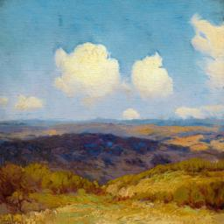

Maurice Quentin de La Tour / Prince Xavier of Saxony / None / Rococo


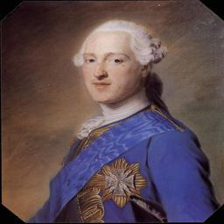

Richard Diebenkorn / Landscape with Figure / None / Abstract Expressionism


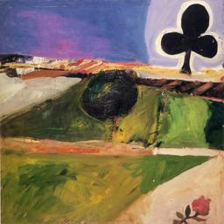

In [ ]:
for x in iter(wikiart.take(3)):
    print(x["artist"], x["title"], x["date"], x["style"], sep=" / ")
    display(x["image"])

Calculating embeddings for the image and title using the models we've loaded is a simple task:


In [ ]:
for x in iter(wikiart.take(1)):
    img_embedding = image_encoder.encode([x["image"]], convert_to_tensor=True)
    text_embedding = text_encoder.encode([x["title"]], convert_to_tensor=True)

    print(img_embedding.shape, text_embedding.shape)

torch.Size([1, 512]) torch.Size([1, 512])


This produces embeddings of size `512`. The image encoder requires a list of PIL `Image`s as input, while the text encoder takes a list of strings.

Since we can't reset the streaming iterator to the start, we'll create it again.


In [ ]:
wikiart = load_dataset(dataset_path, split="train", streaming=True)
wikiart = wikiart.map(process, batched=True, batch_size=512)

## (c) Create Milvus vector database

So far, we've loaded our embedding models, the dataset we're embedding, and demonstrated how to embed images and text. As we calculate the embeddings for each painting, we will store them in a Milvus vector database. In this section, we will set up the database.

First, we create the database file on our local machine, define a schema for each row, and add a collection, similar to a table in a relational database. By opening a connection to a `.db` file, we're using Milvus Lite, a version suited for single machines and notebooks. It's worth noting that the API is nearly identical for Milvus Standalone, Milvus Distributed, and Zilliz CLoud.

We will store both the text embedding for each painting's caption and the corresponding image embedding in the same row, using a Milvus feature called `multivectors`. For convenience, we will store the image itself in each row, though we could reduce the database size by providing a filepath to each painting's JPEG, as these files are stored separately.


In [ ]:
from pymilvus import CollectionSchema, DataType, FieldSchema, MilvusClient

milvus_client = MilvusClient(uri="multimodal_demo.db")

fields = [
    FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=True),
    FieldSchema(name="textVector", dtype=DataType.FLOAT_VECTOR, dim=512),
    FieldSchema(name="imageVector", dtype=DataType.FLOAT_VECTOR, dim=512),
    FieldSchema(name="title", dtype=DataType.VARCHAR, max_length=128),
    FieldSchema(name="style", dtype=DataType.VARCHAR, max_length=128),
    FieldSchema(name="genre", dtype=DataType.VARCHAR, max_length=128),
    FieldSchema(name="artist", dtype=DataType.VARCHAR, max_length=128),
    FieldSchema(name="image", dtype=DataType.ARRAY, element_type=DataType.INT8),
]

schema = CollectionSchema(fields=fields, enable_dynamic_field=False)
collection_name = "wikiart"

index_params = milvus_client.prepare_index_params()

index_params.add_index(
    field_name="textVector", index_type="AUTOINDEX", metric_type="COSINE"
)

index_params.add_index(
    field_name="imageVector", index_type="AUTOINDEX", metric_type="COSINE"
)

if milvus_client.has_collection(collection_name=collection_name):
    milvus_client.drop_collection(collection_name=collection_name)

milvus_client.create_collection(
    collection_name, metric_type="COSINE", schema=schema, index_params=index_params
)

print(milvus_client.list_collections())

['wikiart']


The database is now ready to accept new entries.


## (d) Encode images and text and insert into database


The final step before we can search our painting dataset is to embed all the images and captions and build the database. We accomplish this using the following loop over `wikiart_pt`, which calculates the embeddings, makes minor adjustments to the metadata, and inserts batches into the database.

(Note that this inference loop is quite suboptimal. Much of the loop's time is spent compressing images to JPEG while the GPU remains idle. On my machine with an RTX 4090, this process takes about 21 minutes, but it would take only about 3 minutes without image compression. In the future, I plan to create a new dataset where resizing and image compression are already completed and uploaded to HuggingFace. This would simplify the tutorial significantly.)


In [ ]:
batch_size = 512
wikiart_pt = DataLoader(
    wikiart["train"].with_format("torch"), batch_size=batch_size, num_workers=4
)

for idx, x in tqdm(enumerate(wikiart_pt)):
    title = [s.strip().lower() for s in x["title"]]
    style = [s.strip().lower() for s in x["style"]]
    genre = [s.strip().lower() for s in x["genre"]]
    artist = [s.strip().lower() for s in x["artist"]]

    images = [
        torchvision.transforms.functional.to_pil_image(x["image"][jdx])
        for jdx in range(x["image"].shape[0])
    ]

    image_b64 = []
    for img in images:
        buffered = BytesIO()
        img.save(buffered, format="JPEG")
        image_b64.append(base64.b64encode(buffered.getvalue()))

    img_embeddings = image_encoder.encode(
        images, batch_size=batch_size, convert_to_tensor=True
    )
    img_embeddings = F.normalize(img_embeddings).cpu().numpy().tolist()
    del x["image"]
    del images

    title_embeddings = text_encoder.encode(
        title, batch_size=batch_size, convert_to_tensor=True
    )
    title_embeddings = F.normalize(title_embeddings).cpu().numpy().tolist()

    batch_data = zip(
        range((idx * batch_size), (idx * batch_size) + len(title)),
        title_embeddings,
        img_embeddings,
        title,
        style,
        genre,
        artist,
        image_b64,
    )

    data = [
        {
            "id": id,
            "textVector": textVector,
            "imageVector": imageVector,
            "title": title,
            "style": style,
            "genre": genre,
            "artist": artist,
            "image": image,
        }
        for id, textVector, imageVector, title, style, genre, artist, image in batch_data
    ]

    # TODO: Error detection
    res = collection.insert(data=data)

204it [21:29,  6.32s/it]


The embeddings are normalized so that the dot product (also known as the inner product) between them equals the cosine distance.

We wrap the HuggingFace `IterableDataset` in a PyTorch `DataLoader` to leverage multiple CPUs for preprocessing the images. However, this approach has a downside: PIL Images get converted into tensors, requiring us to convert them back to PIL format. Subclassing `DataLoader` might offer a solution to this issue.

If everything goes as planned, our database will contain `103,250` rows.


In [ ]:
collection.flush()
print(collection.num_entities)
assert collection.num_entities == 103250

We have successfully constructed our database and can now perform some interesting searches.

# 2. Search vector database


Let's create helper functions to search our database. We use a feature of Milvus called [hybrid search](https://milvus.io/docs/multi-vector-search.md) to search separate indices and combine the results into a single set. We combine the results using a re-ranker, specifically the [reciprocal rank fusion](https://milvus.io/docs/reranking.md#Reciprocal-Rank-Fusion-RRFRanker) method.


In [ ]:
def searchRequest(query_vectors, field, limit=5, filter=None):
    return AnnSearchRequest(
        **{
            "data": query_vectors,
            "anns_field": field,
            "param": {
                "metric_type": "IP",
            },
            "limit": limit,  # Number of search results to return in this AnnSearchRequest
            "expr": filter,
        }
    )


def searchByText(query: str, limit=3, filter=None, searchText=True, searchImages=True):
    """
    Return top matches to a text query, searching over both text and image embeddings.
    """
    query_vectors = text_encoder.encode([query])
    query_vectors = query_vectors / np.linalg.norm(query_vectors)

    assert searchText == True or searchImages == True
    reqs = []

    if searchText:
        reqs.append(
            searchRequest(query_vectors, "textVector", limit=limit, filter=filter)
        )
    if searchImages:
        reqs.append(
            searchRequest(query_vectors, "imageVector", limit=limit, filter=filter)
        )

    rerank = RRFRanker()
    res = collection.hybrid_search(
        reqs=reqs,
        rerank=rerank,
        limit=limit,
        output_fields=["id", "artist", "title", "image"],
    )

    return res[0]

In [ ]:
def base64ToImage(image):
    im_bytes = base64.b64decode(image)
    im_file = BytesIO(im_bytes)
    return PilImage.open(im_file)


def printResults(res):
    for x in res:
        print(x.artist, x.title, sep=" / ")
        img = base64ToImage(bytearray(x.image))
        display(img)

The function `searchByText()` takes a text string as the input query and performs several types of searches. You can conduct a hybrid search across both text and image embeddings or search using just one of them. Additionally, you can pass in a filtering expression to filter on the metadata.


## (a) Combining image and text vector search vs searching each separately


What benefits come from embedding both a text and an image of each painting? Why not just embed the image and perform a search on it? Let's compare the results of a search query using both indices, only the text index, and only the image index.


Here are the results for the query 'the starry night' searching both images and text:


vincent van gogh / the starry night


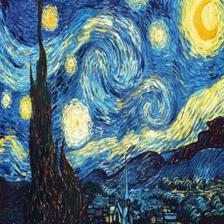

konstantin bogaevsky / corona astralis


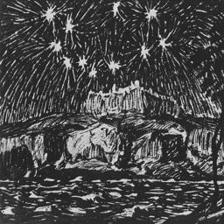

vincent van gogh / the starry night


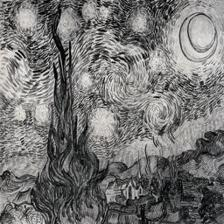

theodor severin kittelsen / december


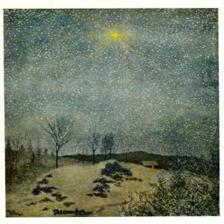

victor pasmore / the starry night


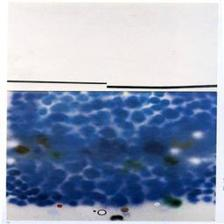

andrea loney / none


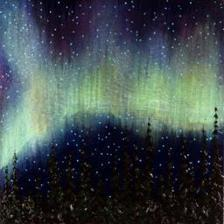

vincent van gogh / the starry night


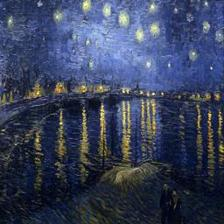

In [ ]:
res = searchByText("the starry night", limit=7)
printResults(res)

Here are the same results but searching just the titles:


vincent van gogh / the starry night


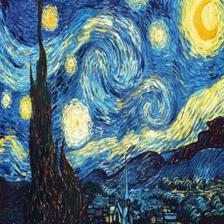

vincent van gogh / the starry night


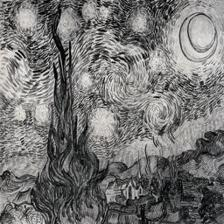

victor pasmore / the starry night


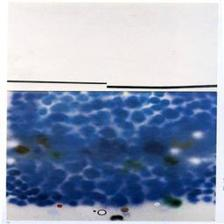

vincent van gogh / the starry night


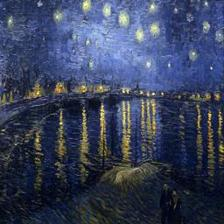

edvard munch / starry night


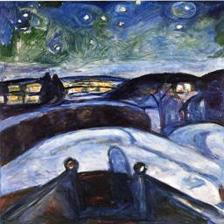

konstantin vasilyev / the starry sky


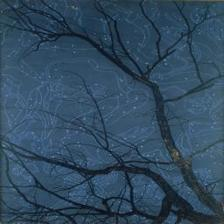

sven jonson / den ljusa natten


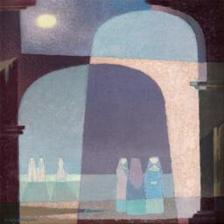

In [ ]:
res = searchByText("the starry night", limit=7, searchText=True, searchImages=False)
printResults(res)

You can see that all the titles of the resulting images resemble the query. Interestingly, our CLIP model, which is multilingual, can embed the Swedish phrase "den ljusa natten," translating to "the bright night."

Let's compare now to searching just the images.


konstantin bogaevsky / corona astralis


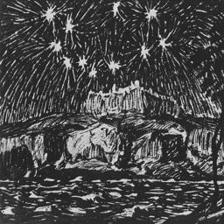

theodor severin kittelsen / december


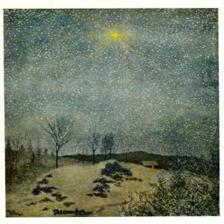

andrea loney / none


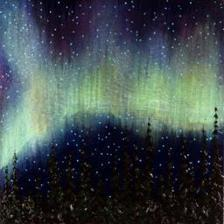

albert bierstadt / campfire site, yosemite


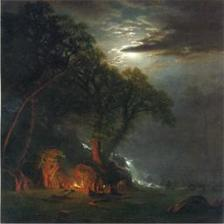

nicholas roerich / russian easter


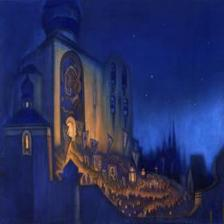

ivan aivazovsky / moonlit night on the crimea. gurzuf


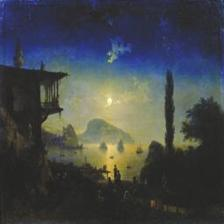

andrea loney / none


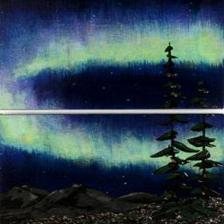

In [ ]:
res = searchByText("the starry night", limit=7, searchText=False, searchImages=True)
printResults(res)

The results include paintings featuring a night sky with stars or the aurora borealis, which cannot be fully inferred from the title alone. While these results are sensible, they do not include Van Gogh's impressionist painting _The Starry Night_. In this instance, the title aids the search by clarifying the abstract representation of stars in the painting. This example demonstrates how combining image and text in hybrid search can yield more relevant results than using either method alone.


## (b) Filtering search on metadata


Let's perform some searches now to demonstrate filtering by metadata. Suppose we want to find paintings from Picasso's Blue Period. We will search for the term "blue" and filter by the artist field:


pablo picasso / ascet


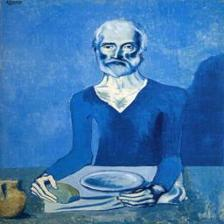

pablo picasso / melancholy woman


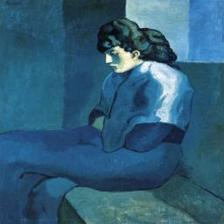

pablo picasso / crouching woman


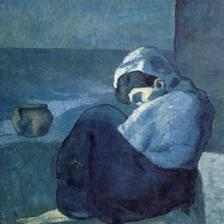

pablo picasso / portrait of seniora soler (girl in a chemise)


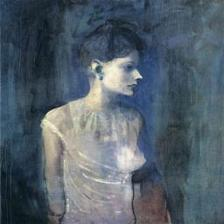

pablo picasso / the tragedy


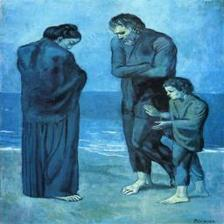

pablo picasso / the roofs of barcelona in the moonlight


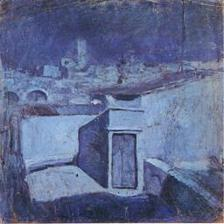

pablo picasso / a blue acrobat


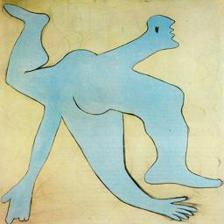

In [ ]:
res = searchByText(
    "blue", limit=7, filter='artist == "pablo picasso"', searchText=False
)
printResults(res)

This method seems to have successfully found paintings from the Blue Period.

To find paintings from Picasso's Cubist Period, you can search for the term "cubist" and filter by the artist field:


pablo picasso / woman with guitar


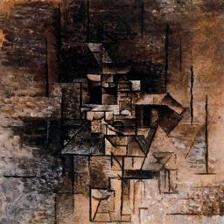

pablo picasso / portrait of daniel-henry kahnweiler


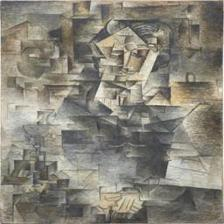

pablo picasso / guitar player


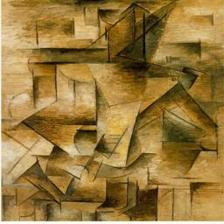

pablo picasso / my beautiful (woman with guitar)


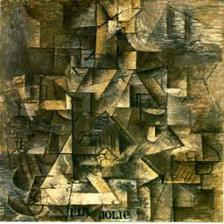

pablo picasso / the student


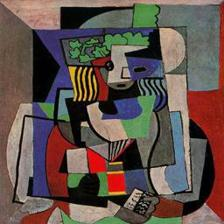

pablo picasso / clarinet, bottle of bass, newspaper, ace of clubs


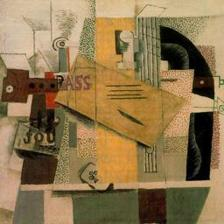

pablo picasso / window opened to the street penthieure


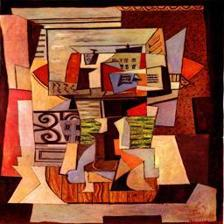

In [ ]:
res = searchByText(
    "cubist", limit=7, filter='artist == "pablo picasso"', searchText=False
)
printResults(res)

Once again, we can search for a style or theme of painting by a given artist in our dataset.

For another example, we'll search for Picasso's paintings that examine the theme of love.


pablo picasso / reading


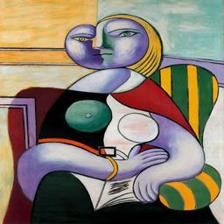

pablo picasso / standing nude


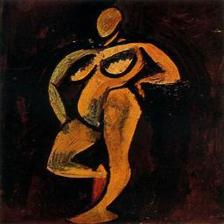

pablo picasso / the embrace


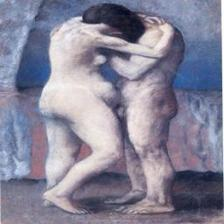

pablo picasso / lovers of the street


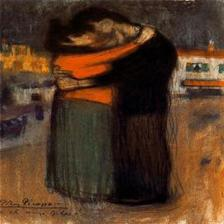

pablo picasso / seated woman


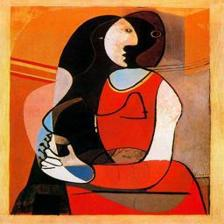

pablo picasso / embrace


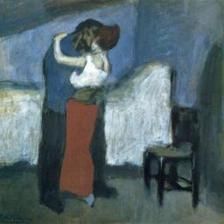

pablo picasso / two figures


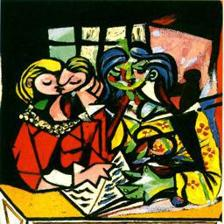

In [ ]:
res = searchByText(
    "love", limit=7, filter='artist == "pablo picasso"', searchText=False
)
printResults(res)

With the exception of the first image, the other results seem relevant. The model might be confused by the Cubist approach, which can make the subject appear as if it's two people.


## (c) A failure mode of search

Up to this point, we have demonstrated successfully relevant search results. However, there are cases where neither the image nor the caption embedding fully capture the meaning of a painting's description. For example, consider "The Persistence of Memory" by Salvador Dalí.


salvador dali / the persistence of memory


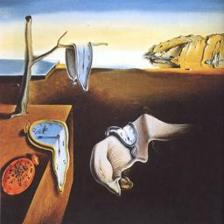

In [ ]:
res = searchByText("persistence memory", limit=1, filter='artist == "salvador dali"')
printResults(res)

Searching by a description of the painting does not successfully retrieve it from the database.


salvador dali / nuclear cross


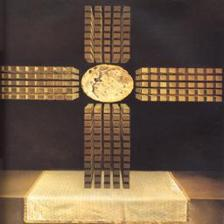

salvador dali / l'etoile


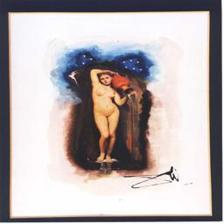

salvador dali / homage to meirronier


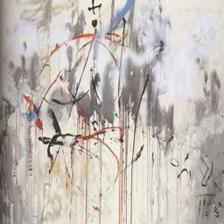

salvador dali / set design for the ballet 'los sacos del molinero'


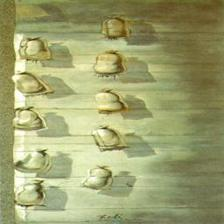

salvador dali / couple with clouds in their heads (woman)


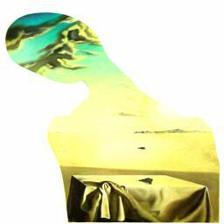

salvador dali / gradiva


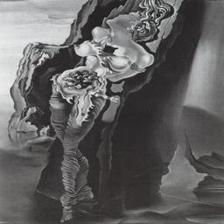

salvador dali / sybyle agripa


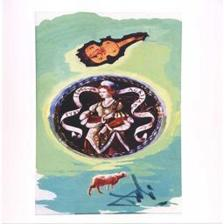

In [ ]:
res = searchByText(
    "melting pocket watches", limit=7, filter='artist == "salvador dali"'
)
printResults(res)

You can try other similar descriptions to see if you can successfully retrieve the painting. One possible solution is to use a large language-vision model (LLVM) to create a detailed description of the painting, embed these synthetic descriptions, and search through these embeddings instead. Perhaps a topic for another day?


## 3. Closing Thoughts

In this notebook, we developed a search tool for a dataset containing both images and text. We demonstrated how to generate multimodal embeddings, insert them into a vector database, and conduct various searches.

While we applied the embedding model to art paintings, the approach is also applicable to online products and other domains. More broadly, we can embed multiple modalities into the same space for similarity search if we have the appropriate model or the necessary data to train it. For example, you could embed audio, text, and images for a multimedia dictionary, or embed videos, images, and text to search company meetings.

We used a dataset of around 100,000 samples, but you can scale to hundreds of millions, billions, or even trillions using a distributed vector database like Milvus. With the techniques outlined in this notebook, you can perform multimodal search on a web scale!

Like this content? Our next notebook will delve into LLVMs and multimodal rag.
